## Change of coordinates

In [ ]:
import sys
from math import cos, radians, sin
from pathlib import Path

import folium
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

project_root = Path.cwd().resolve().parents[1]
sys.path.append(str(project_root))  

from config import Color  # noqa: E402
from helpers.change_coordinates import poses  # noqa: E402
from mavlink.customtypes.location import ENUPose, GRAPose  # noqa: E402
from plan.planner import Plan  # noqa: E402


In [2]:
def draw_enupose(
    ax: Axes,
    pose: ENUPose,
    label: str,
    color: str,
    alpha: float = 1.0
):
    """Draws an ENUPose on a matplotlib Axes with an arrow and label."""
    x, y, _, h = pose
    arrow_scale = 2  # in meters

    dx = cos(radians(h)) * arrow_scale
    dy = sin(radians(h)) * arrow_scale

    ax.arrow(# type: ignore
        x, y, dx, dy,
        head_width=arrow_scale * 0.5,
        color=color,
        alpha=alpha,
        length_includes_head=True
    )  
    ax.text(x, y, label, color=color, alpha=alpha)  # type: ignore


def draw_grapose(
    map_obj: folium.Map,
    pose: GRAPose,
    label: str,
    color: str
):
    """Draws a GRAPose as a marker on a folium map."""
    lat, lon, _, _ = pose
    folium.Marker(
        location=[lat, lon],
        popup=label,
        icon=folium.Icon(color=color)
    ).add_to(map_obj)

In [3]:
homes = ENUPose.list([  # east, north, up, heading
    #(0., 0., 0., 0),
    (20., 0., 0., 20),
    (0, -20., 0., 0),
    # (-15., 0., 0., 0.),
    # (0., -20., 0., 0.),
])

paths = [
    Plan.create_square_path(
        side_len=10, alt=5, heading=0, clockwise=True
    ) for _ in homes
]


h_paths = [poses(home,path) for home,path in zip(homes,paths)]
colors=[
    Color.BLUE.value,
    Color.GREEN.value,
    # Color.YELLOW.value,
    # Color.ORANGE.value,
    # Color.RED.value,
]

## ENU

In [4]:
origin = ENUPose(30, 0, 0, 45)
o_paths = [poses(origin,path) for path in h_paths]

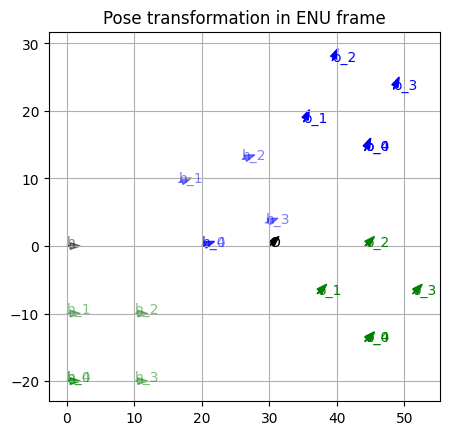

In [5]:
fig, ax = plt.subplots()# type: ignore
ax.set_aspect("equal")
ax.grid(True)# type: ignore
draw_enupose(ax,origin, "O", "black")
draw_enupose(ax,ENUPose(0,0,0,0), "h", "black",alpha=0.5)
for h_path,o_path,color in zip(h_paths,o_paths,colors):
    for i,(h_pos,o_pos) in enumerate(zip(h_path,o_path)):
        draw_enupose(ax,h_pos, f"h_{i}", color,alpha=0.5)  # plotted relative to origin, visually shifted
        draw_enupose(ax,o_pos, f"o_{i}", color)
plt.title("Pose transformation in ENU frame")# type: ignore
plt.show()# type: ignore

## GRA 

In [6]:
origin = GRAPose(-35.3633245, 149.1652241, 0, 45)
o_paths = [poses(origin,path) for path in h_paths]

In [7]:
lat0, lon0, *_ = origin
m = folium.Map(location=[lat0, lon0], zoom_start=18)

# Plot each UAV's path
for path, color in zip(o_paths, colors):  # add more colors if needed
    for i, pose in enumerate(path):
        draw_grapose(m, pose, f"o_{i}", color)

# Plot origin
draw_grapose(m, origin, "Origin", "black")

m
